In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.16 (default, Jan 17 2023, 23:13:24) 
[GCC 11.2.0]
Pytorch: 1.10.2+cu102
Fastai: 2.5.3


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
import torch
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import cv2
import tqdm

## Load your data

In [23]:
# coco_dataset_folder = '/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset-BRUMAS/dataset_BRUMAS_v1/'
# coco_dataset_folder = "/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/"
coco_dataset_folder = "/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/UNIMIB16/"
# coco_dataset_folder = "/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/"

coco = COCO(coco_dataset_folder + "CocoData_preprocessed_final.json")

imgIds = list(sorted(coco.imgs.keys()))
len(imgIds)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


897

In [24]:
cats = coco.loadCats(coco.getCatIds())
categories = [cat['name'] for cat in cats]
categoriesId = [cat['id'] for cat in cats]

len(categories)

33

/tmp/ipykernel_4144/4290073017.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


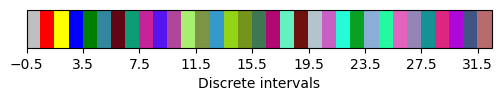

In [25]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(categories))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) 
cmaplist[1] = "red" 
cmaplist[2] = "yellow" 
cmaplist[3] = "blue" 
cmaplist[4] = "green" 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(categories)+1)] # intervals must contain integer values, so the bounds should increase every 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

## Check for noisy data

In [26]:
# check if ground truth is noisy (optional)

import cv2
import numpy as np

def isNoisyAnnotation(masks):

    #### check if masks have high iou between each other
    intersectionThreshold = 0.3
    for mask1 in masks: 
        for mask2 in masks: # compare every mask with each other 
            if not np.array_equal(mask1,mask2): 
                intersectionPixels = np.sum(np.logical_and(mask1, mask2))
                smallestMask = min(np.sum(mask1),np.sum(mask2))
                percentualIntersection = intersectionPixels / smallestMask
                # print(percentualIntersection)
                if percentualIntersection > intersectionThreshold:
                    print("Masks with high intersection")
                    return True

    #### check if exists multiple contours in one mask and if these regions are too small
    areaThreshold = 0.01
    maxContours = 1

    for mask in masks:    
        mask = mask * 255 # transform binary mask from (0,1) format to (0,255)

        # fig = plt.figure(figsize=(9,9))
        # ax1 = fig.add_subplot(1,2,1)
        # ax1.imshow(mask)
        # plt.show()

        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        numContours = len(contours)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area == 0.0:
                print("Found zero area")
                numContours -= 1
                continue

            totalPixels = mask.shape[0] * mask.shape[1]
            # print(area/totalPixels)
            if area/totalPixels < areaThreshold:
                # print("Very Small contour")
                return True

        # print(numContours)
        if numContours == 0:
            print("No contours")
            return True    

        if numContours > maxContours:
            # print("Multiple contours")
            return True

    return False

## Data visualization functions

In [27]:
# generate data visualization 

import functools

def getThickEdge(mask, rgbValues):
    edge = cv2.Canny(mask*255, 30, 150)

    kernel = np.ones((5,5), np.uint8)
    edge_dilated = cv2.dilate(edge, kernel, iterations=1)

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[edge_dilated == 255], g[edge_dilated == 255], b[edge_dilated == 255] = rgbValues
    coloured_edge = np.stack([r, g, b], axis=2)

    # fig = plt.figure(figsize=(9,9))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(coloured_edge)
    # plt.show()

    return coloured_edge

    
def random_colour_masks(mask):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    randomNumber = random.randrange(0,10)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[randomNumber]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask, colours[randomNumber]

def mergeImgAndMasks(img, masks):

    for i in range(len(masks)):
        rgb_mask, rgbValues = random_colour_masks(masks[i])
        edge_mask = getThickEdge(masks[i], rgbValues)
        
        if img.shape != rgb_mask.shape:
            return None, None

        img = cv2.addWeighted(img, 1, rgb_mask, 0.2, 0)
        img = cv2.addWeighted(img, 1, edge_mask, 1, 0)

    return img

def getAllMasksAndClasses(anns):
    masks = []
    for i in range(len(anns)):
        masks.append(coco.annToMask(anns[i]))

    catIds = [ann["category_id"] for ann in anns]
    catNames = [categories[categoriesId.index(id)] for id in catIds]

    return masks, catNames, catIds


def concatMasks(mask1, mask2):
    bothNotZero = np.logical_and(mask1, mask2)
    mask2[bothNotZero] = 0
    return mask1+mask2

def getSingleMaskWithLabels(masks, classesIds):
    gt_masksWithLabel = []
    for gt_id, gt_mask in zip(classesIds, masks):
        gt_masksWithLabel.append(gt_mask*gt_id)
    mask = functools.reduce(concatMasks, gt_masksWithLabel)
    return mask

def getVisualization(img_id, returnOriginalMask=False, checkNoisyAnnotation=True, classesToIgnore=[], classesToVisualize=[], checkByName=True):
    imgName = coco.loadImgs(img_id)[0]['file_name']
    imgPath = os.path.join(coco_dataset_folder, "done", imgName)
    img = cv2.imread(imgPath)

    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    anns = coco.loadAnns(annIds)
    masks, classes, classesIds = getAllMasksAndClasses(anns)
    mask = getSingleMaskWithLabels(masks, classesIds) # only works with number of classes smaller than 255

    # check classes by name or ids
    if checkByName:
        classesData = classes
    else:
        classesData = classesIds
    
    intersectionIgnore = list(set(classesData) & set(classesToIgnore))
    if len(intersectionIgnore) > 0: # classes to ignore were found
        # print("Found class to ignore")
        # print(classesData, classesToIgnore)
        return None, None, None
    
    intersectionVisualize = list(set(classesData) & set(classesToVisualize))
    if len(classesToVisualize) > 0 and len(intersectionVisualize) == 0: # classes to visualize were not found 
        # print("Did not find classes to visualize")
        # print(classesData, classesToVisualize)
        return None, None, None
        
    if checkNoisyAnnotation and isNoisyAnnotation(masks): # noisy image was found
        return None, None, None

    mergedImg = mergeImgAndMasks(img, masks)
    if mergedImg is None:
        print(f"Problem merging image and mask: {img_id}")

    imgs = [cv2.imencode('.jpeg', mergedImg)[1].tobytes()]

    if returnOriginalMask:
        colorMask = cmap(mask, bytes=True)
        imgs.append(cv2.imencode('.jpeg', colorMask)[1].tobytes())
        
    return imgs, classes, classesIds
   

## Configure iteration

In [31]:
# configuration

# checkByName = True
# classesToIgnore = []
# classesToVisualize=["Cenoura", "Alface"]

checkByName = False
classesToIgnore = []
classesToVisualize=[]

returnOriginalMask=True
checkNoisyAnnotation=False

# how big are the images?
width=300
height=300
columns=4  # 7 for 150,  4 for 300 

# how many samples you want to iterate?
init = 0
end = 200
# end = len(imgIds)

## Iterate Data

In [32]:
from IPython.display import display
from ipywidgets import widgets, HBox, VBox, GridBox, Layout, GridspecLayout
import math

pickedSamples = []
samplesToIgnore = []

def createButton(file):
    layout = widgets.Layout()
    button = widgets.Button(description='Pick', layout = layout)

    def on_button_clicked(event, file=file):
        pickedSamples.append(file)
        button.description = "Done"
        button.disabled = True

    button.on_click(on_button_clicked)
    return button

items = []
for idx in range(init,end):
    img_id = imgIds[idx]
    imgName = coco.loadImgs(img_id)[0]['file_name']
    imgs, classes, classesIds = getVisualization(img_id, returnOriginalMask=returnOriginalMask, checkNoisyAnnotation=checkNoisyAnnotation,
                                     classesToIgnore=classesToIgnore, classesToVisualize=classesToVisualize, checkByName=checkByName)
    
    if imgs is None: # found image with ids to ignore or noisy annotation
        samplesToIgnore.append(imgName)
        continue       

    images = [widgets.Image(value=img,width=width,height=height) for img in imgs]
    button = createButton(imgName)
    # numClasses = widgets.Label(value=str(len(classes)))
    names = [widgets.Label(value=f"{className}: {classId}") for className, classId in zip(classes,classesIds)]

    visualization = [button] + images + names
    items.append(VBox(visualization))

rows = math.ceil(len(items)/columns)
grid = GridspecLayout(rows, columns, grid_gap="10px")
cont = 0
for i in range(rows):
    for j in range(columns):
        try:
            grid[i, j] = items[cont]
            cont+=1
        except:
            continue
        
print(f"Ignored {len(samplesToIgnore)} samples")
display(grid)


Ignored 0 samples


GridspecLayout(children=(VBox(children=(Button(description='Pick', style=ButtonStyle()), Image(value=b'\xff\xd…

In [ ]:
print(len(pickedSamples))
print(pickedSamples)

print(len(samplesToIgnore))
print(samplesToIgnore)

## Save data

In [37]:
# save picked images to file

filepath = coco_dataset_folder + f"pickedImages_init={init}_end={end}.txt"

textfile = open(filepath, "w")
for element in pickedSamples:
    textfile.write(element + "\n")
textfile.close()


In [44]:
# save ignored images to file

filepath = coco_dataset_folder + f"ignoredImages_init={init}_end={end}.txt"

textfile = open(filepath, "w")
for element in samplesToIgnore:
    textfile.write(element + "\n")
textfile.close()